In [1]:
%matplotlib inline
import torch
from torch import Tensor
from torch.distributions import Normal
import matplotlib.pyplot as plt
import math

torch.manual_seed(42)

In [2]:
def next_obs(current_l: Tensor = torch.tensor([0., 0.]),
             a: Tensor = torch.tensor([1., 1.]),
             F: Tensor = torch.tensor([[1., 1.], [0., 1.]]),
             alpha: float = 0.6, beta: float = 0.6,
             sigma_t: float = 3.0):

    g = torch.tensor([alpha, beta])

    y_t = (a * current_l).sum()
    obs_noise = sigma_t * torch.randn(1).item()
    z_t = y_t + obs_noise
    state_noise = torch.randn(1).item()
    next_l = F.matmul(current_l) + g * state_noise
    return next_l, z_t


def simulate_single_ts(n_obs: int = 39):
    current_state = torch.tensor([0., 3.])
    obs_list = []
    for _ in range(n_obs):
        current_state, z = next_obs(current_l=current_state)
        obs_list.append(z.item())
    return torch.tensor(obs_list)

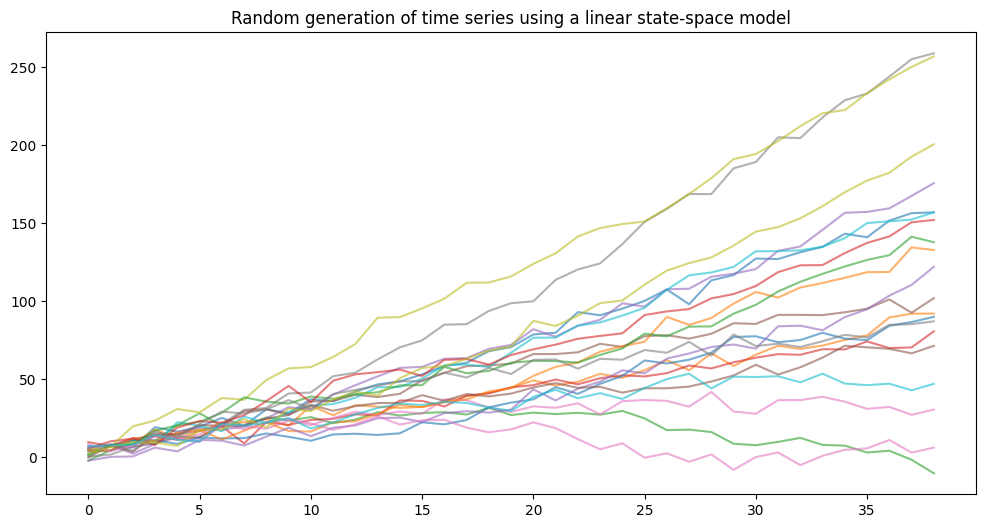

In [3]:
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(simulate_single_ts(), alpha=0.6)
plt.title('Random generation of time series using a linear state-space model')
plt.show()

In [4]:
class LevelTrendSSM:

    a = torch.tensor([1., 1.])
    F = torch.tensor([[1., 1.], [0., 1.]])

    def __init__(self, ts_data: Tensor):
        self.ts_data = ts_data.float()
        self.g = None
        self.sigma_t = None
        self.prediction_list = []
        self.states_list = []

    @property
    def predictions(self):
        return self.prediction_list

    @property
    def states(self):
        return self.states_list

    def _filter_init(self, alpha: float = 1.0, beta: float = 1.0,
                     sigma_t: float = 3.0,
                     f_0: Tensor = torch.tensor([0., 0.]),
                     S_0: Tensor = torch.diag(torch.tensor([1., 1.]))):

        self.g = torch.tensor([alpha, beta])
        self.sigma_t = float(sigma_t)
        # Predict observation for t=0 from prior
        z_mu = (self.a * f_0).sum()
        z_var = (self.a.unsqueeze(0) @ S_0 @ self.a.unsqueeze(1)).item() + (self.sigma_t ** 2)
        # Update step using first observation
        residual = self.ts_data[0] - z_mu
        # Kalman gain K = S0 a / z_var  (S0 @ a) / z_var
        K = (S_0 @ self.a) / z_var          # shape (2,)
        f_current = f_0 + K * residual
        # Joseph form simplified
        S_current = S_0 - torch.ger(K, (self.a @ S_0))
        return z_mu, z_var, f_current, S_current

    def filter_ts(self, alpha: float = 1.0, beta: float = 1.0,
                  sigma_t: float = 3.0,
                  f_0: Tensor = torch.tensor([0., 0.]),
                  S_0: Tensor = torch.diag(torch.tensor([3., 3.]))):
        self.prediction_list = []
        self.states_list = []
        z_mu, z_var, f_current, S_current = self._filter_init(alpha=alpha, beta=beta,
                                                              sigma_t=sigma_t, f_0=f_0, S_0=S_0)
        self.prediction_list.append([z_mu, z_var])
        self.states_list.append([f_current, S_current])
        # iterate through remaining observations
        for datum in self.ts_data[1:]:
            # state prediction
            f_pred = self.F.matmul(f_current)
            S_pred = self.F.matmul(S_current).matmul(self.F.T) + torch.ger(self.g, self.g)
            # observation forecast
            mu_pred = (self.a * f_pred).sum()
            var_pred = (self.a.unsqueeze(0) @ S_pred @ self.a.unsqueeze(1)).item() + (self.sigma_t ** 2)
            self.prediction_list.append([mu_pred, var_pred])
            # update with observation
            residual = datum - mu_pred
            K = (S_pred @ self.a) / var_pred
            f_current = f_pred + K * residual
            S_current = S_pred - torch.ger(K, (self.a @ S_pred))
            self.states_list.append([f_current, S_current])

    def predict(self, horizon: int):
        assert horizon >= 1
        if not self.states_list:
            raise ValueError('Call filter_ts() first.')
        outputs = []
        f_current, S_current = self.states_list[-1]
        for _ in range(horizon):
            f_current = self.F.matmul(f_current)
            S_current = self.F.matmul(S_current).matmul(self.F.T) + torch.ger(self.g, self.g)
            mu_pred = (self.a * f_current).sum()
            var_pred = (self.a.unsqueeze(0) @ S_current @ self.a.unsqueeze(1)).item() + (self.sigma_t ** 2)
            outputs.append([mu_pred, var_pred])
        return outputs


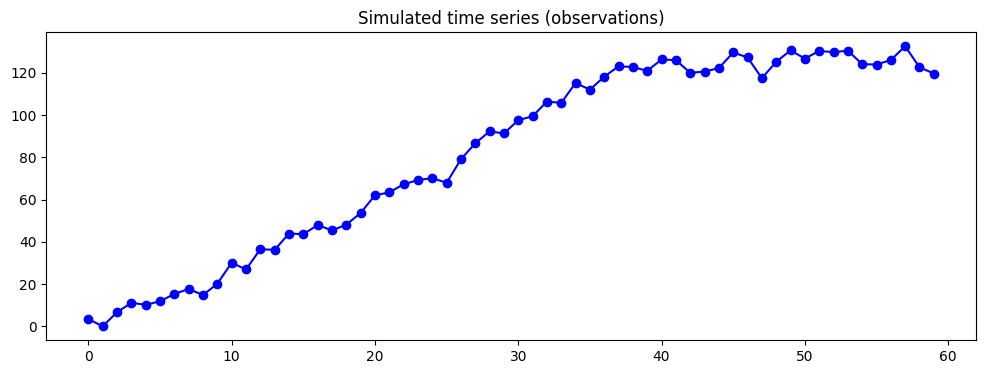

In [5]:
ts_sim = simulate_single_ts(n_obs=60)
plt.figure(figsize=(12, 4))
plt.plot(ts_sim.numpy(), 'bo-', label='Simulated observations')
plt.title('Simulated time series (observations)')
plt.show()

In [6]:
ssm = LevelTrendSSM(ts_sim)
ssm.filter_ts()                      # default init
preds = ssm.predictions              # list of [mu, var]
pred_mus = [p[0] for p in preds]
pred_stds = [math.sqrt(p[1]) for p in preds]

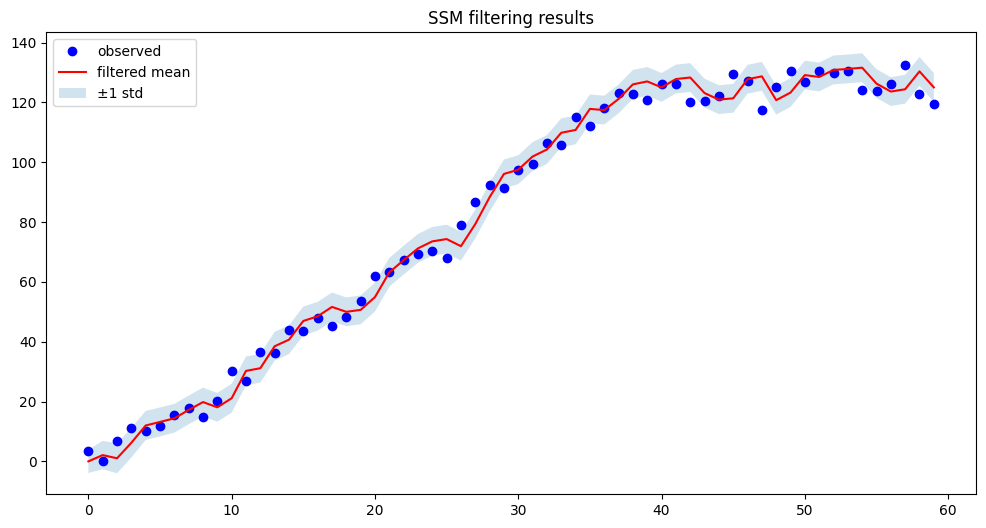

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(ts_sim.numpy(), 'bo', label='observed')
plt.plot(pred_mus, 'r-', label='filtered mean')
plt.fill_between(range(len(pred_mus)),
                 [m - s for m, s in zip(pred_mus, pred_stds)],
                 [m + s for m, s in zip(pred_mus, pred_stds)],
                 alpha=0.2, label='±1 std')
plt.legend()
plt.title('SSM filtering results')
plt.show()

In [8]:
# Predict 5 steps ahead
future = ssm.predict(5)
f_mus = [f[0] for f in future]
f_stds = [math.sqrt(f[1]) for f in future]
print('Future predicted means:', f_mus)

Future predicted means: [tensor(119.9740), tensor(118.2379), tensor(116.5019), tensor(114.7658), tensor(113.0298)]
